# Using BERT on the SQuAD v1 Dataset

In [1]:
pip install transformers datasets torch tqdm scikit-learn nltk evaluate tqdm matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 33.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 KB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 69.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 KB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 100.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 KB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 KB 161.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 KB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 KB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 KB 21.0 MB/s eta 0:00:00
   

### Load Dataset

In [2]:
import splitData

train_ds, val_ds, test_ds = splitData.load_and_split_data()

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]


Stats for training data:
count    78839.000000
mean       119.725656
std         49.337913
min         20.000000
50%        110.000000
90%        183.000000
95%        213.000000
99%        282.000000
max        653.000000
dtype: float64


## Load BERT

In [18]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    get_linear_schedule_with_warmup,
    default_data_collator,
    BertConfig
)
import evaluate
from tqdm.auto import tqdm
from torch.optim import AdamW
import time
import numpy as np
from postprocessQA import postprocess_qa_predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
model_name = "bert-base-uncased"
config = BertConfig.from_pretrained(
    model_name,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
model.to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [5]:
batch_size = 8
eval_batch= 16
epochs = 10
learning_rate = 3e-5

### Pre-Process Data

In [6]:
max_len = 512    
doc_stride = 128    
pad_on_right = tokenizer.padding_side == "right"

In [7]:
def train_preprocess_fn(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=max_len,
        truncation="only_second" if pad_on_right else "only_first",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_map = tokenized.pop("overflow_to_sample_mapping")
    offset_map = tokenized.pop("offset_mapping")

    starts, ends = [], []
    for i, offsets in enumerate(offset_map):
        seq_ids = tokenized.sequence_ids(i)
        example_i  = sample_map[i]
        answer = examples["answers"][example_i]

        if not answer["answer_start"]:
            starts.append(0); ends.append(0)
            continue

        start_char= answer["answer_start"][0]
        end_char = start_char +len(answer["text"][0])
        ctx_idxs = [idx for idx, sid in enumerate(seq_ids) if sid == (1 if pad_on_right else 0)]
        first_ctx, last_ctx = ctx_idxs[0], ctx_idxs[-1]

        if not (offsets[first_ctx][0] <= start_char and offsets[last_ctx][1] >= end_char):
            starts.append(0); ends.append(0)
            continue

        valid_starts = [idx for idx in ctx_idxs if offsets[idx][0] <= start_char]
        valid_ends = [idx for idx in ctx_idxs if offsets[idx][1] >= end_char]
        starts.append(max(valid_starts) if valid_starts else first_ctx)
        ends.append(min(valid_ends) if valid_ends else last_ctx)

    tokenized["start_positions"] = starts
    tokenized["end_positions"]   = ends
    return tokenized

In [8]:
train_features = train_ds.map(train_preprocess_fn,batched=True,remove_columns=train_ds.column_names)
train_loader = DataLoader(train_features, batch_size=batch_size,shuffle=True, collate_fn=default_data_collator)

Map:   0%|          | 0/78839 [00:00<?, ? examples/s]

In [9]:
def eval_preprocess_fn(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=max_len,
        truncation="only_second" if pad_on_right else "only_first",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_map = tokenized["overflow_to_sample_mapping"]
    tokenized["example_id"] = [examples["id"][i] for i in sample_map]
    return tokenized

In [ ]:
val_features = val_ds.map(eval_preprocess_fn, batched=True,remove_columns=val_ds.column_names)
test_features = test_ds.map(eval_preprocess_fn, batched=True, remove_columns=test_ds.column_names)

val_loader= DataLoader(val_features, batch_size=eval_batch,shuffle=False,collate_fn=default_data_collator)
test_loader = DataLoader(test_features,batch_size=eval_batch,shuffle=False,collate_fn=default_data_collator)

Map:   0%|          | 0/8760 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [11]:
val_labelled = val_ds.map(
    train_preprocess_fn,
    batched=True,
    remove_columns=val_ds.column_names
)
val_labelled_loader = DataLoader(
    val_labelled,batch_size=eval_batch, shuffle=False,
    collate_fn=default_data_collator
)

Map:   0%|          | 0/8760 [00:00<?, ? examples/s]

## HyperParams

In [12]:
total_steps = len(train_loader) * epochs
optim = AdamW(
    model.parameters(),
    lr=1e-5,                
    weight_decay=0.01       
)
sched = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
gradient_accumulation_steps = 2 

# Training

In [22]:
history = {
    "train_loss": [], 
    "val_loss": [],
    "val_em": [],
    "val_f1": []
}
best_val_loss = float("inf")
patience = 2
stale = 0
metric_squad = evaluate.load("squad") 

In [ ]:
total_time = 0.0
for epoch in range(1, epochs + 1):
    epoch_start = time.time()

    # ─── TRAIN 
    model.train()
    total_train_loss = 0.0

    for step, batch in enumerate(tqdm(train_loader, desc=f"[{epoch}] train")):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optim.step(); sched.step(); optim.zero_grad()

        total_train_loss += loss.item()* gradient_accumulation_steps

    avg_train = total_train_loss / len(train_loader)
    history["train_loss"].append(avg_train)

    # ─── VALIDATION 
    model.eval()
    metric_squad     = evaluate.load("squad")
    val_losses       = []
    all_start_logits = []
    all_end_logits   = []

    for loss_batch, feat_batch in tqdm(zip(val_labelled_loader, val_loader),
                                       total=len(val_loader),
                                       desc=f"[{epoch}] eval"):
        loss_inputs = {k: v.to(device) for k, v in loss_batch.items()}
        with torch.no_grad():
            out = model(**loss_inputs)
        val_losses.append(out.loss.item())
        all_start_logits.append(out.start_logits.cpu().numpy())
        all_end_logits.append(out.end_logits.cpu().numpy())

    avg_val = sum(val_losses) / len(val_losses)
    history["val_loss"].append(avg_val)
    flat_start = np.concatenate(all_start_logits, axis=0)
    flat_end   = np.concatenate(all_end_logits,   axis=0)
    final_preds = postprocess_qa_predictions(
        examples=val_ds,         
        features=val_features,   
        predictions=(flat_start, flat_end),
        version_2_with_negative=False,
        n_best_size=20,
        max_answer_length=30,
    )

    # ─── COMPUTE EM/F1 
    metric_squad.add_batch(
        predictions=[{"id": eid, "prediction_text": text}
                     for eid, text in final_preds.items()],
        references=[{"id": ex["id"], "answers": ex["answers"]}
                    for ex in val_ds]
    )
    res_val = metric_squad.compute()
    history["val_em"].append(res_val["exact_match"])
    history["val_f1"].append(res_val["f1"])

    # ─── EARLY STOP / SAVE BEST 
    if avg_val < best_val_loss:
        best_val_loss = avg_val; stale = 0
        model.save_pretrained("best-bert-squad")
        tokenizer.save_pretrained("best-bert-squad")
    else:
        stale +=1
        if stale >= patience:
            print(f"Stopping early at epoch {epoch} (no improvement in {patience} epochs).")
            break

    epoch_time =time.time() - epoch_start
    total_time += epoch_time
    print(
        f"Epoch {epoch:2d} | "
        f"train_loss={avg_train:.4f} | "
        f"val_loss={avg_val:.4f} "
        f"(EM={res_val['exact_match']:.2f}, F1={res_val['f1']:.2f}) | "
        f"time={epoch_time:.1f}s"
    )

print(f"\nTotal training time: {total_time:.1f}s")

[1] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[1] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Epoch  1 • train_loss=2.8606 • val_loss=1.2934 (EM=58.36, F1=73.12) • time=954.7s


[2] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[2] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Epoch  2 • train_loss=1.2151 • val_loss=1.0567 (EM=64.55, F1=78.76) • time=953.2s


[3] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[3] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Epoch  3 • train_loss=0.9345 • val_loss=0.9884 (EM=66.69, F1=80.42) • time=952.8s


[4] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[4] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Epoch  4 • train_loss=0.7271 • val_loss=1.0600 (EM=67.37, F1=80.93) • time=952.7s


[5] train:   0%|          | 0/9868 [00:00<?, ?it/s]

[5] eval:   0%|          | 0/549 [00:00<?, ?it/s]

  0%|          | 0/8760 [00:00<?, ?it/s]

Stopping early at epoch 5 (no improvement in 2 epochs).

Total training time: 3813.3s


## View Training Metrics

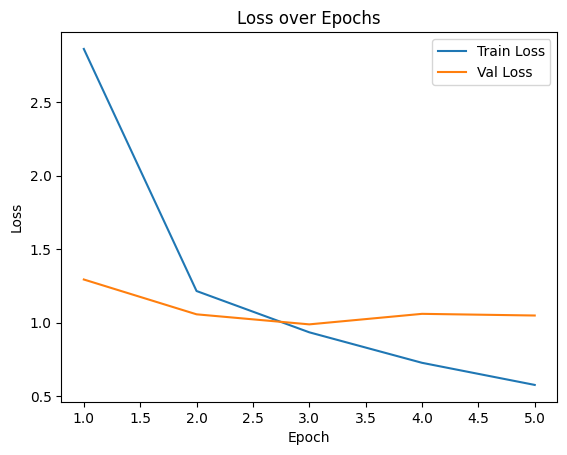

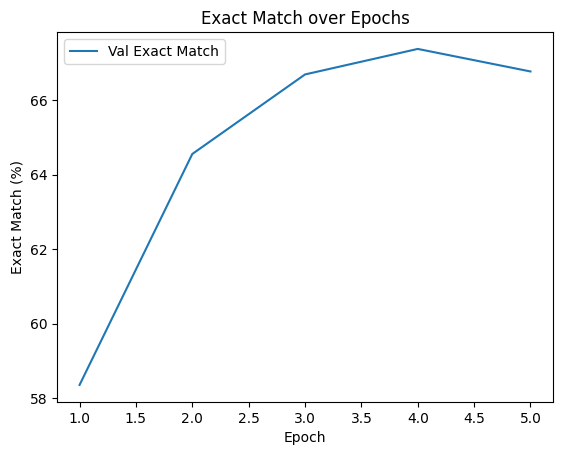

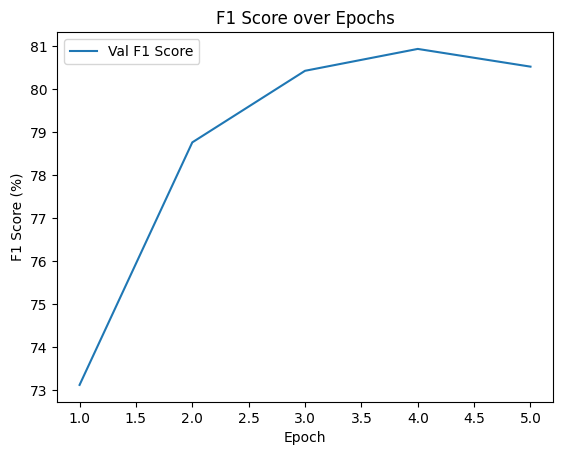

In [24]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.savefig("loss_plot.png")
plt.show()

plt.figure()
plt.plot(epochs_range, history["val_em"], label="Val Exact Match")
plt.xlabel("Epoch")
plt.ylabel("Exact Match (%)")
plt.title("Exact Match over Epochs")
plt.legend()
plt.savefig("em_plot.png")
plt.show()

plt.figure()
plt.plot(epochs_range, history["val_f1"], label="Val F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score (%)")
plt.title("F1 Score over Epochs")
plt.legend()
plt.savefig("f1_plot.png")
plt.show()

## Test

### Load Saved Model

In [25]:
model = AutoModelForQuestionAnswering.from_pretrained("best-bert-squad").to(device)
tokenizer = AutoTokenizer.from_pretrained("best-bert-squad")

In [26]:
import random

### Visualize some Q/A

In [27]:
model.eval()

n_show = 5
indices = random.sample(range(len(test_ds)), n_show)

for idx in indices:
    example = test_ds[idx]
    question = example["question"]
    context = example["context"]
    answers = example["answers"]["text"]  #ground-truth answers

    # tokenize
    inputs = tokenizer(
        question,
        context,
        return_tensors="pt",
        max_length=512,
        truncation=True,
        return_offsets_mapping=True,
    ).to(device)

    with torch.no_grad():
        outs = model(**{k: v for k, v in inputs.items() if k in ("input_ids","attention_mask","token_type_ids")})

    start_logits = outs.start_logits[0].cpu()
    end_logits= outs.end_logits[0].cpu()
    offset_map = inputs["offset_mapping"][0].cpu()

    start_idx = torch.argmax(start_logits)
    end_idx= torch.argmax(end_logits)

    char_start = offset_map[start_idx][0].item()
    char_end = offset_map[end_idx][1].item()

    pred_answer = context[char_start:char_end]

    print(f"\nExample #{idx}")
    print(f"Q: {question}")
    print(f"\n{context[:200].replace(chr(10),' ')}")  
    print(f"\nPredicted:\n {pred_answer}")
    print(f"Ground-truth:\n {answers}\n")


Example #8036
Q: What lab does the university have a joint stake in? 

The university operates 12 research institutes and 113 research centers on campus. Among these are the Oriental Institute—a museum and research center for Near Eastern studies owned and operated by th

Predicted:
 Fermilab
Ground-truth:
 ['Fermilab', 'Fermilab', 'Fermilab']


Example #7500
Q: What career does Joseph Stiglitz have?

Economist Joseph Stiglitz argues that rather than explaining concentrations of wealth and income, market forces should serve as a brake on such concentration, which may better be explained by the non-

Predicted:
 Economist
Ground-truth:
 ['Economist', 'Economist', 'Economist']


Example #8946
Q: Which amino acids contain sulfur?

Chloroplasts alone make almost all of a plant cell's amino acids in their stroma except the sulfur-containing ones like cysteine and methionine. Cysteine is made in the chloroplast (the proplastid too

Predicted:
 cysteine and methionine
Ground-truth:
 ['cystei

### Custom Q/A over the Magna Carta

In [28]:
model.eval()

questions = ["What is the importance of the Magna Carta?", "When was the magna carta written?", 
             "Who wrote the magna carta?", "Who was the ruler of England when the magna carta was written?",
            "Who tried to supress the magna carta?", "Who was inspired by the Magna Carta?"
            ]
context  = "Magna Carta Libertatum (Medieval Latin for Great Charter of Freedoms), commonly called Magna Carta or sometimes Magna Charta (Great Charter),[a] is a royal charter[4][5] of rights agreed to by King John of England at Runnymede, near Windsor, on 15 June 1215.[b] First drafted by the Archbishop of Canterbury, Cardinal Stephen Langton, to make peace between the unpopular king and a group of rebel barons who demanded that the King confirm the Charter of Liberties, it promised the protection of church rights, protection for the barons from illegal imprisonment, access to swift and impartial justice, and limitations on feudal payments to the Crown, to be implemented through a council of 25 barons. Neither side stood by their commitments, and the charter was annulled by Pope Innocent III, leading to the First Barons War. After Johns death, the regency government of his young son, Henry III, reissued the document in 1216, stripped of some of its more radical content, in an unsuccessful bid to build political support for their cause. At the end of the war in 1217, it formed part of the peace treaty agreed at Lambeth, where the document acquired the name Magna Carta, to distinguish it from the smaller Charter of the Forest, which was issued at the same time. Short of funds, Henry reissued the charter again in 1225 in exchange for a grant of new taxes. His son, Edward I, repeated the exercise in 1297, this time confirming it as part of Englands statute law. However, Magna Carta was not unique; other legal documents of its time, both in England and beyond, made broadly similar statements of rights and limitations on the powers of the Crown. The charter became part of English political life and was typically renewed by each monarch in turn, although as time went by and the fledgling Parliament of England passed new laws, it lost some of its practical significance. At the end of the 16th century, there was an upsurge in interest in Magna Carta. Lawyers and historians at the time believed that there was an ancient English constitution, going back to the days of the Anglo-Saxons, that protected individual English freedoms. They argued that the Norman invasion of 1066 had overthrown these rights and that Magna Carta had been a popular attempt to restore them, making the charter an essential foundation for the contemporary powers of Parliament and legal principles such as habeas corpus.  It influenced the early American colonists in the Thirteen Colonies and the formation of the United States Constitution, which became the supreme law of the land in the new republic of the United States. Research by Victorian historians showed that the original 1215 charter had concerned the medieval relationship between the monarch and the barons, and not ordinary subjects. Despite the changes in views of historians, the charter has remained a powerful, iconic document, even after almost all of its content was repealed from the statute books in the 19th and 20th centuries. Magna Carta still forms an important symbol of liberty today, often cited by politicians and campaigners, and is held in great respect by the British and American legal communities, Lord Denning describing it in 1956 as the greatest constitutional document of all times—the foundation of the freedom of the individual against the arbitrary authority of the despot. In the 21st century, four exemplifications of the original 1215 charter remain in existence, two at the British Library, one at Lincoln Castle and one at Salisbury Cathedral. There are also a handful of the subsequent charters in public and private ownership, including copies of the 1297 charter in both the United States and Australia. The 800th anniversary of Magna Carta in 2015 included extensive celebrations and discussions, and the four original 1215 charters were displayed together at the British Library. None of the original 1215 Magna Carta is currently in force since it has been repealed; however, four clauses of the original charter are enshrined in the 1297 reissued Magna Carta and do still remain in force in England and Wales.[c]"

for question in questions:
    # tokenize
    inputs = tokenizer(
        question,
        context,
        return_tensors="pt",
        max_length=512,
        truncation=True,
        return_offsets_mapping=True,
    ).to(device)
    
    with torch.no_grad():
        outs = model(**{k: v for k, v in inputs.items() if k in ("input_ids","attention_mask","token_type_ids")})
    
    start_logits = outs.start_logits[0].cpu()
    end_logits   = outs.end_logits[0].cpu()
    offset_map   = inputs["offset_mapping"][0].cpu()
    
    start_idx = torch.argmax(start_logits)
    end_idx   = torch.argmax(end_logits)
    
    char_start = offset_map[start_idx][0].item()
    char_end   = offset_map[end_idx][1].item()
    
    pred_answer = context[char_start:char_end]
    
    print(f"Q: {question}")
    #print(f"Context: \n {context[:200].replace(chr(10),' ')}...")  
    print(f"Predicted: \n {pred_answer}")

Q: What is the importance of the Magna Carta?
Predicted: 
 protection of church rights
Q: When was the magna carta written?
Predicted: 
 15 June 1215
Q: Who wrote the magna carta?
Predicted: 
 Cardinal Stephen Langton
Q: Who was the ruler of England when the magna carta was written?
Predicted: 
 King John of England
Q: Who tried to supress the magna carta?
Predicted: 
 Pope Innocent III
Q: Who was inspired by the Magna Carta?
Predicted: 
 Pope Innocent III


In [29]:
from transformers import PreTrainedTokenizerFast

def eval_preprocess_fn(examples):
    tokenized = tokenizer(
        examples["question"],
        examples["context"],
        max_length=max_len,
        truncation="only_second",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = tokenized.pop("overflow_to_sample_mapping")
    offset_map = tokenized.pop("offset_mapping")
    tokenized["example_id"]  = []
    tokenized["offset_mapping"] = []

    for i, sample_idx in enumerate(sample_map):
        tokenized["example_id"].append(examples["id"][sample_idx])
        seq_ids = tokenized.sequence_ids(i)
        offsets = [
            off if seq_ids[k] == 1 else None
            for k, off in enumerate(offset_map[i])
        ]
        tokenized["offset_mapping"].append(offsets)
    return tokenized

# Compute Final Metrics on Test Data

In [30]:
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer
import evaluate

qa = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0)

metric = evaluate.load("squad")  

predictions, references = [], []
for ex in test_ds:
    out = qa(question=ex["question"], context=ex["context"])
    predictions.append({"id": ex["id"], "prediction_text": out["answer"]})
    references.append({"id": ex["id"], "answers": ex["answers"]})

results = metric.compute(predictions=predictions, references=references)
print(f"Exact Match: {results['exact_match']:.2f}%")
print(f"F1 : {results['f1']:.2f}%")

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Exact Match: 78.81%
F1 : 86.77%
